In [1]:
import pandas as pd
import json
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [3]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch

In [4]:
class model(nn.Module):
    def __init__(self, checkpoint, freeze=False, device='cpu'):
        super().__init__()
        
        self.model = AutoModel.from_pretrained(checkpoint)
        # set device cuda or cpu
        self.device = device
        # freeze model
        if freeze:
            for layer in self.model.parameters():
                layer.requires_grad=False
        
    def forward(self, x, attention_mask=None):
            
        x = x.to(self.device)
        # pooler_output(seq,dim) 
        with torch.no_grad():
            model_out = self.model(x['input_ids'], x['attention_mask'], return_dict=True)
            
        embds = model_out.last_hidden_state # model_out[0][:,0]
        mean_pool = embds.sum(axis=1) / x['attention_mask'].sum(axis=1).unsqueeze(axis=1)
        return mean_pool

In [5]:
# DONE! NO NEED TO RUN THIS CELL

# checkpoint = 'distilbert-base-uncased'
# distilbert = model(checkpoint, freeze=True)
# distilbert.to('cpu')
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [6]:
dtypes = {'cfips': str}
df = pd.read_csv('gpt_pro_con_no_null.csv', dtype=dtypes)
df.head()

,cfips,gpt_pro_1,gpt_pro_2,gpt_pro_3,gpt_con_1,gpt_con_2,gpt_con_3
0,01001,"Autauga County has a low cost of living, makin...","The county has a strong business community, pr...",Autauga County is located in the heart of Alab...,Autauga County has a relatively small populati...,The county has a limited number of resources a...,Autauga County is subject to the laws and regu...
1,01003,Baldwin County has a strong economy with a low...,"The cost of living is relatively low, making i...",There are numerous resources available to help...,The local government has strict regulations an...,"The area is prone to natural disasters, such a...",There is a limited pool of skilled labor avail...
2,01005,"Low cost of living in Barbour County, Alabama,...",Access to a large customer base due to the cou...,Access to a variety of resources and support f...,Limited access to capital and financing option...,Lack of access to a skilled workforce due to t...,Limited access to technology and infrastructur...
3,01007,"Low cost of living in Bibb County, Alabama, ma...",Access to a large customer base due to the cou...,Access to a variety of resources and support f...,Limited access to capital and financing option...,Limited access to skilled labor due to the cou...,Limited access to technology and infrastructur...
4,01009,"Low cost of living in Blount County, Alabama, ...",Access to a large customer base due to the cou...,Access to resources such as the Blount County ...,Limited access to venture capital and other fo...,Limited access to skilled labor due to the cou...,Limited access to technology and other resourc...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cfips      3142 non-null   object
 1   gpt_pro_1  3142 non-null   object
 2   gpt_pro_2  3142 non-null   object
 3   gpt_pro_3  3142 non-null   object
 4   gpt_con_1  3142 non-null   object
 5   gpt_con_2  3142 non-null   object
 6   gpt_con_3  3142 non-null   object
dtypes: object(7)
memory usage: 172.0+ KB


In [8]:
# # manually fill in null values for missing pro/con
# # NO NEED TO RUN THIS CELL

# df.loc[81, 'gpt_pro_1'] = 'Low competition: Kusilvak Census Area is a rural region with few businesses, which means that there is a significant opportunity for entrepreneurs to establish a presence in the market.'
# df.loc[81, 'gpt_pro_2'] = 'Supportive community: The region has a strong sense of community, and small business owners can expect to receive support and referrals from locals.'
# df.loc[81, 'gpt_pro_3'] = 'Potential for growth: Kusilvak Census Area is experiencing population growth, which suggests a growing market for goods and services.'
# df.loc[81, 'gpt_con_1'] = 'High costs: The region has a high cost of living, which translates to higher expenses for businesses in terms of rent, supplies, and utilities.'
# df.loc[81, 'gpt_con_2'] = 'Harsh weather: Kusilvak Census Area experiences long, cold winters, which can make it challenging to transport goods and services and can impact the economy.'
# df.loc[81, 'gpt_con_3'] = 'Limited access to resources: As a remote region, Kusilvak Census Area has limited access to resources such as skilled labor, equipment, and funding, which can hinder the growth of a small business.'

# df.loc[1127, 'gpt_pro_1'] = 'Low cost of living: With a lower cost of living, small businesses can potentially save money on expenses such as rent and utilities.'
# df.loc[1127, 'gpt_pro_2'] = 'Supportive community: Concordia Parish has a tight-knit community that is supportive of small businesses, making it easier to build a customer base and get word-of-mouth referrals.'
# df.loc[1127, 'gpt_pro_3'] = 'Access to resources: The region has resources like the Concordia Economic Development office, small business development centers, and networking events that can help small businesses get off the ground.'
# df.loc[1127, 'gpt_con_1'] = 'Limited customer base: Concordia Parish has a small population, which could limit the number of potential customers for a small business.'
# df.loc[1127, 'gpt_con_2'] = 'Competition: The small business market in Concordia Parish may already be saturated with similar businesses, making it difficult to stand out.'
# df.loc[1127, 'gpt_con_3'] = 'Limited access to skilled labor: There may be limited access to skilled labor in the region, making it more difficult to find qualified employees.'

# df.loc[2412, 'gpt_pro_1'] = 'Low Cost of Living: Oglala Lakota County offers a low cost of living compared to other areas, allowing for cheaper rent, labor costs, and other expenses.'
# df.loc[2412, 'gpt_pro_2'] = 'Tax Benefits: The county offers several tax incentives for small businesses, including a tax abatement program for new businesses and a reduced tax rate for property.'
# df.loc[2412, 'gpt_pro_3'] = 'Supportive Community: The local community is supportive of small businesses, with several resources available, such as the Lakota Funds, which provides financing and technical assistance.'
# df.loc[2412, 'gpt_con_1'] = 'Limited Market: The county has a small population, which may limit the potential customer base for certain businesses.'
# df.loc[2412, 'gpt_con_2'] = 'Geographic Isolation: The county is remote and may be challenging to reach for suppliers and customers, leading to increased transportation costs.'
# df.loc[2412, 'gpt_con_3'] = 'Workforce Shortages: The area may have a limited pool of skilled workers, making it difficult to find qualified employees for certain industries.'

# df.to_csv('gpt_pro_con_no_null.csv', index=False)
# df.isnull().sum()

In [9]:
def read_csv_to_sentences(df):
    docs = []
    for i in range(len(df)):
        docs.append(df['gpt_pro_1'][i])
        docs.append(df['gpt_pro_2'][i])
        docs.append(df['gpt_pro_3'][i])
        docs.append(df['gpt_con_1'][i])
        docs.append(df['gpt_con_2'][i])
        docs.append(df['gpt_con_3'][i])
    return docs

In [10]:
docs = read_csv_to_sentences(df)
final_sentences = docs

In [11]:
# # NO NEED TO RUN AGAIN, ALREADY SAVED AS JSON FILE

# # dataloader
# final_embeddings = list()
# all_embeddings = []

# final_sentences = docs

# batch_sz = 200 # batch_size
# for idx in range(0, len(final_sentences), batch_sz):
#     batch_sentences = final_sentences[idx:idx+batch_sz]
#     for sent in batch_sentences:
#         tokens = tokenizer(sent ,truncation='longest_first', return_tensors='pt', return_attention_mask=True,padding=True)
#         embeddings = distilbert(tokens)
#         final_embeddings.extend(embeddings)
#         all_embeddings = torch.stack(final_embeddings)

# with open('distillBERT_embeddings.json', 'w') as f:
#     json.dump(all_embeddings.tolist(), f)

In [12]:
# load embeddings
with open('distillBERT_embeddings.json') as f:
    all_embeddings = json.load(f)

In [13]:
positive_embeddings = []
negative_embeddings = []
for i in range(len(all_embeddings)):
    if i % 6 == 0 or i % 6 == 1 or i % 6 == 2:
        positive_embeddings.append(all_embeddings[i])
    else:
        negative_embeddings.append(all_embeddings[i])

positive_sentences = []
negative_sentences = []
for i in range(len(final_sentences)):
    if i % 6 == 0 or i % 6 == 1 or i % 6 == 2:
        positive_sentences.append(final_sentences[i])
    else:
        negative_sentences.append(final_sentences[i])

In [14]:
positive_sentences[:6]

['Autauga County has a low cost of living, making it an affordable place to start a business.',
 'The county has a strong business community, providing resources and support for entrepreneurs.',
 'Autauga County is located in the heart of Alabama, providing easy access to major cities and transportation hubs.',
 'Baldwin County has a strong economy with a low unemployment rate.',
 'The cost of living is relatively low, making it an attractive place to start a business.',
 'There are numerous resources available to help small businesses get started, such as the Small Business Development Center and the Baldwin County Economic Development Alliance.']

In [15]:
negative_sentences[:6]

['Autauga County has a relatively small population, which may limit the potential customer base for a small business.',
 'The county has a limited number of resources and services available to small businesses.',
 'Autauga County is subject to the laws and regulations of the state of Alabama, which may be restrictive for certain types of businesses.',
 'The local government has strict regulations and taxes that can be difficult to navigate.',
 'The area is prone to natural disasters, such as hurricanes and floods, which can disrupt business operations.',
 'There is a limited pool of skilled labor available in the area, making it difficult to find qualified employees.']

## 20 clusters

In [16]:
# set seed for the KMeans clustering
np.random.seed(222)

In [17]:
positive_clusterer = KMeans(n_clusters=10, verbose=0)
positive_clustered_docs = positive_clusterer.fit_predict(positive_embeddings)

negative_clusterer = KMeans(n_clusters=10, verbose=0)
negative_clustered_docs = negative_clusterer.fit_predict(negative_embeddings)

In [18]:
# positive cluster matric
positive_cluster_labels = positive_clusterer.labels_
positive_cluster_centers = positive_clusterer.cluster_centers_

# negative cluster matric
negative_cluster_labels = negative_clusterer.labels_
negative_cluster_centers = negative_clusterer.cluster_centers_

In [19]:
len(positive_cluster_labels)/3 , len(negative_cluster_labels)/3

(3142.0, 3142.0)

In [20]:
positive_matched_list = list(zip(positive_sentences, positive_cluster_labels))
negative_matched_list = list(zip(negative_sentences, negative_cluster_labels))

In [21]:
def get_cluster_sentences(first, last, some_list):
    for i in range(first, last):
        print(f'Cluster {i}:')
        j = 0
        for sentence, cluster in some_list:
            if cluster == i:
                print(sentence)
                j += 1
            if j == 7:
                break

In [22]:
get_cluster_sentences(7, 10, positive_matched_list)

Cluster 7:
The county has a strong business community, providing resources and support for entrepreneurs.
Autauga County is located in the heart of Alabama, providing easy access to major cities and transportation hubs.
Baldwin County has a strong economy with a low unemployment rate.
Dallas County has a strong workforce, providing access to skilled labor.
Elmore County is located in a prime location, with easy access to major cities and transportation hubs.
Greene County is located in a prime location for businesses, with easy access to major cities and transportation hubs.
Houston County has a diverse economy, providing a variety of potential customers.
Cluster 8:
Access to a large customer base due to the county's population of over 27,000 people.
Access to a large customer base due to the county's proximity to Birmingham and other major cities.
Access to a large customer base due to the county's population of over 57,000 people.
Access to a large customer base due to the county's p

In [23]:
get_cluster_sentences(7, 10, negative_matched_list)

Cluster 7:
Limited access to venture capital and other forms of financing.
Limited access to venture capital and other forms of financing.
Limited access to venture capital and other forms of financing
Limited access to venture capital and other forms of financing
Limited access to venture capital and other forms of financing
Limited access to venture capital and other forms of financing
Limited access to venture capital and other forms of financing
Cluster 8:
Low population density, making it difficult to reach potential customers.
Low population density, making it difficult to reach a large customer base
Low population density, making it difficult to reach potential customers.
Low population density in the area, making it difficult to reach potential customers.
Extreme weather conditions can make operations difficult
High cost of doing business due to the remote location
Difficult to attract and retain qualified employees due to the remote location
Cluster 9:
Autauga County has a rel

In [24]:
positive_cluster_names = {
    0: 'Supportive_Community',
    1: 'Low_Cost_of_Living',
    2: 'Government_Support',
    3: 'Large_Customer_Base',
    4: 'Low_Cost_of_Living',
    5: 'Low_Cost_of_Living',
    6: 'Natural_Resources',
    7: 'Connected_Economy',
    8: 'Large_Customer_Base',
    9: 'Government_Support'
}

negative_cluster_names = {
    0: 'Limited_Tech_n_Infra',
    1: 'Limited_Financing',
    2: 'Tough_Labor_Market',
    3: 'Various_Downsides',
    4: 'Limited_Tech_n_Infra',
    5: 'Tough_Labor_Market',
    6: 'Low_Pop_Bad_Weather',
    7: 'Limited_Financing',
    8: 'Low_Pop_Bad_Weather',
    9: 'Unfavorable_Location'
}

In [25]:
new_positive_cluster_labels = []
for i in range(len(positive_cluster_labels)):
    new_positive_cluster_labels.append(positive_cluster_names[positive_cluster_labels[i]])

new_negative_cluster_labels = []
for i in range(len(negative_cluster_labels)):
    new_negative_cluster_labels.append(negative_cluster_names[negative_cluster_labels[i]])

Text(0.5, 1.0, 'Negative Clusters')

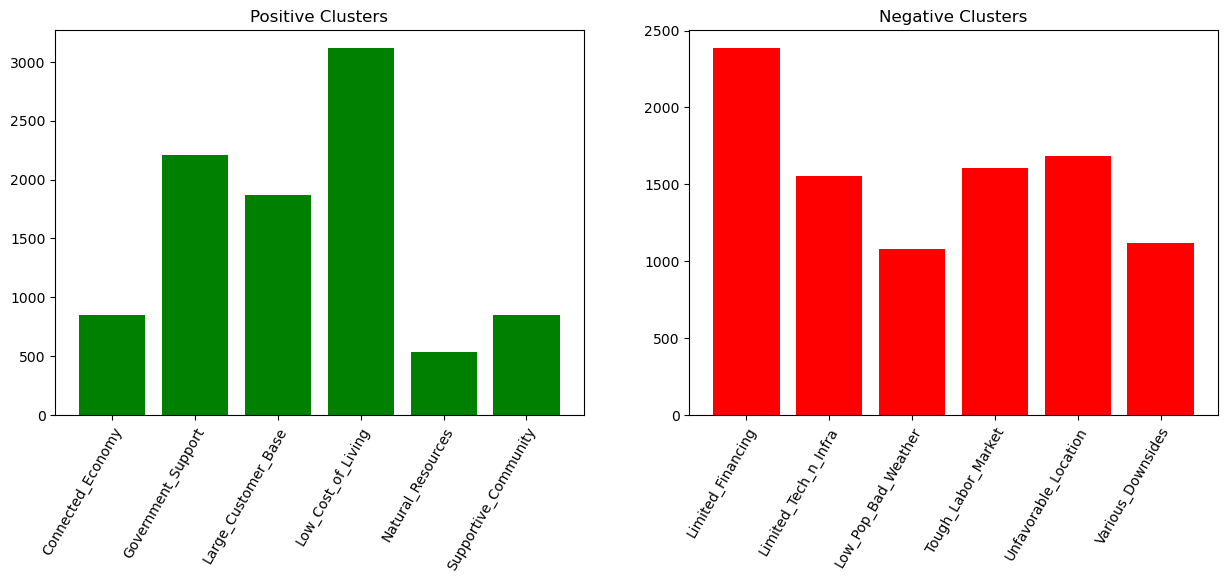

In [26]:
# check the number of sentences in each cluster
pos_labels, positive_counts = np.unique(new_positive_cluster_labels, return_counts=True)
neg_labels, negative_counts = np.unique(new_negative_cluster_labels, return_counts=True)

# plot the number of sentences in each cluster
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# set the ticks to 60 degrees
plt.setp(ax[0].get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")
plt.setp(ax[1].get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")
ax[0].bar(pos_labels, positive_counts, color='green')
ax[0].set_title('Positive Clusters')
ax[1].bar(neg_labels, negative_counts, color='red')
ax[1].set_title('Negative Clusters')

In [27]:
# load the cfips data
dtypes = {'cfips': str}
cfips_df = pd.read_csv('cfips.csv', dtype=dtypes)
cfips_df.head()

,cfips
0,01001
1,01003
2,01005
3,01007
4,01009


In [28]:
pos_labels

array(['Connected_Economy', 'Government_Support', 'Large_Customer_Base',
       'Low_Cost_of_Living', 'Natural_Resources', 'Supportive_Community'],
      dtype='<U20')

In [29]:
cluster_names = []
for label in pos_labels:
    cluster_names.append(str(label))
for label in neg_labels:
    cluster_names.append(str(label))
cluster_names

['Connected_Economy',
 'Government_Support',
 'Large_Customer_Base',
 'Low_Cost_of_Living',
 'Natural_Resources',
 'Supportive_Community',
 'Limited_Financing',
 'Limited_Tech_n_Infra',
 'Low_Pop_Bad_Weather',
 'Tough_Labor_Market',
 'Unfavorable_Location',
 'Various_Downsides']

In [30]:
# make the one-hot encoding df
one_hot_df = pd.DataFrame(columns=['cfips']+cluster_names)
one_hot_df.head()

,cfips,Connected_Economy,Government_Support,Large_Customer_Base,Low_Cost_of_Living,Natural_Resources,Supportive_Community,Limited_Financing,Limited_Tech_n_Infra,Low_Pop_Bad_Weather,Tough_Labor_Market,Unfavorable_Location,Various_Downsides


In [31]:
for i, cfips_str in enumerate(cfips_df['cfips']):
    one_hot_df.loc[i, 'cfips'] = cfips_str
    positives_per_county = new_positive_cluster_labels[3*i:3*i+3]
    negatives_per_county = new_negative_cluster_labels[3*i:3*i+3]
    for comment in positives_per_county:
        one_hot_df.loc[i, comment] = 1
    for comment in negatives_per_county:
        one_hot_df.loc[i, comment] = 1
    for label in cluster_names:
        if label not in positives_per_county and label not in negatives_per_county:
            one_hot_df.loc[i, label] = 0
one_hot_df.head()

,cfips,Connected_Economy,Government_Support,Large_Customer_Base,Low_Cost_of_Living,Natural_Resources,Supportive_Community,Limited_Financing,Limited_Tech_n_Infra,Low_Pop_Bad_Weather,Tough_Labor_Market,Unfavorable_Location,Various_Downsides
0,01001,1,0,0,1,0,0,0,0,0,0,1,0
1,01003,1,1,0,1,0,0,0,0,0,1,0,0
2,01005,0,1,1,1,0,0,0,0,0,1,1,0
3,01007,0,1,1,1,0,0,0,0,0,0,1,0
4,01009,0,1,1,1,0,0,1,0,0,0,1,0


In [32]:
new_positive_cluster_labels[:3], new_negative_cluster_labels[:3]

(['Low_Cost_of_Living', 'Connected_Economy', 'Connected_Economy'],
 ['Unfavorable_Location', 'Unfavorable_Location', 'Unfavorable_Location'])

In [33]:
positive_sentences[:3], negative_sentences[:3]

(['Autauga County has a low cost of living, making it an affordable place to start a business.',
  'The county has a strong business community, providing resources and support for entrepreneurs.',
  'Autauga County is located in the heart of Alabama, providing easy access to major cities and transportation hubs.'],
 ['Autauga County has a relatively small population, which may limit the potential customer base for a small business.',
  'The county has a limited number of resources and services available to small businesses.',
  'Autauga County is subject to the laws and regulations of the state of Alabama, which may be restrictive for certain types of businesses.'])

In [34]:
one_hot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   cfips                 3142 non-null   object
 1   Connected_Economy     3142 non-null   object
 2   Government_Support    3142 non-null   object
 3   Large_Customer_Base   3142 non-null   object
 4   Low_Cost_of_Living    3142 non-null   object
 5   Natural_Resources     3142 non-null   object
 6   Supportive_Community  3142 non-null   object
 7   Limited_Financing     3142 non-null   object
 8   Limited_Tech_n_Infra  3142 non-null   object
 9   Low_Pop_Bad_Weather   3142 non-null   object
 10  Tough_Labor_Market    3142 non-null   object
 11  Unfavorable_Location  3142 non-null   object
 12  Various_Downsides     3142 non-null   object
dtypes: object(13)
memory usage: 408.2+ KB


In [35]:
# fill in ratio of the data frame
total_filled = one_hot_df[cluster_names].sum(axis=1).sum()
total_cells = one_hot_df[cluster_names].shape[0] * one_hot_df[cluster_names].shape[1]
print(f'The ratio of filled cells is {total_filled/total_cells}')

The ratio of filled cells is 0.4481222151495863


In [36]:
# save the one-hot encoding df
one_hot_df.to_csv('gpt_data_one_hot_df.csv', index=False)